<a href="https://colab.research.google.com/github/Ezan/nuclei_segmentation_using_mrcnn/blob/main/nucleus_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implementation of Mask-RCNN for segmentation of cell nuclei**

*Based on pre-trained COCO dataset with fine tuning*

This code is modified from https://colab.research.google.com/github/navidyou/Mask-RCNN-implementation-for-cell-nucleus-detection-executable-on-google-colab-/blob/master/mask_RCNN_cell_nucleus_google_colab.ipynb

In [2]:
!pip install 'h5py==2.10.0' --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, which is not installed.
i

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/MRCNN/')
!ls

logs		   mrcnn	stage1_test.zip  stage1_train.zip
mask_rcnn_coco.h5  stage1_test	stage1_train


In [3]:
!pip install scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os, sys, random, math, re, time, cv2, json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from skimage.io import imread, imread_collection, concatenate_images
from skimage.transform import resize

In [5]:
# Downloading dataset from github. This cell needs execution ONLY ONCE!
# !wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
# !wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

# !mkdir stage1_train stage1_test

# !unzip stage1_train.zip -d stage1_train/
# !unzip stage1_test.zip -d stage1_test/

In [6]:
# Data path
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

# Get IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [7]:
## collab does not support tensorflow 1.x anyumore...this could be a workaround

# !pip uninstall tensorflow
# !pip install tensorflow-gpu==1.15
# !apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0

In [8]:
# ! pip install -U keras==2.1.0

In [9]:
import tensorflow as tf
import skimage
import keras
print(tf.__version__, skimage.__version__, keras.__version__)

1.15.0 0.16.2 2.1.0


Using TensorFlow backend.


In [10]:
from ast import increment_lineno
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
%matplotlib inline

ROOT_DIR = os.getcwd()

MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
#download coco_model
if not os.path.exists(COCO_MODEL_PATH):
  utils.download_trained_weights(COCO_MODEL_PATH)

In [11]:
class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 500

    # set number of epoch
    STEPS_PER_EPOCH = 10

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = ShapesConfig()
config.display()




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  896
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  896
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [896 896   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

Notebook prefenrences

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Dataset
Create a synthetic dataset

Extends the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:

*   load_image()
*   load_mask()
*   image_reference()






In [13]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)

In [14]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

139 51 ['BG', 'nucleus']


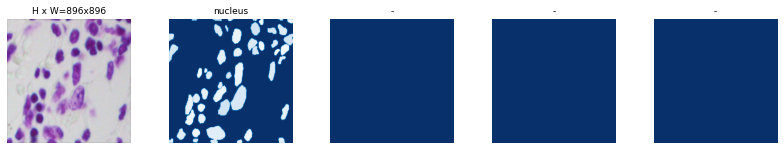

204 36 ['BG', 'nucleus']


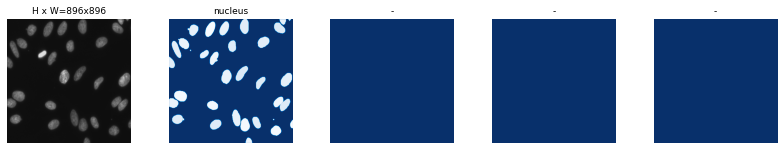

519 64 ['BG', 'nucleus']


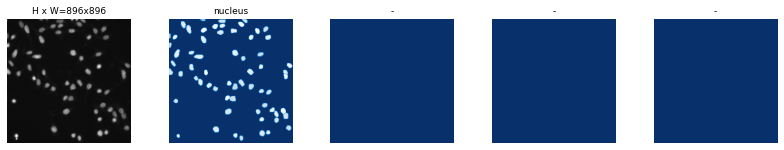

55 33 ['BG', 'nucleus']


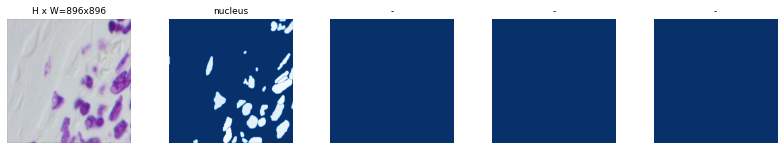

In [15]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image_id, len(class_ids),dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


# Build Model



In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [17]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

# Training


In [18]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/MRCNN/logs/shapes20220916T1744/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Time


/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



/

Epoch 1/1
 9/10 [==========================>...] - ETA: 2:03 - loss: 7.1475 - rpn_class_loss: 1.6933 - rpn_bbox_loss: 2.8343 - mrcnn_class_loss: 0.3455 - mrcnn_bbox_loss: 1.0127 - mrcnn_mask_loss: 1.2617

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



10/10 [==============================] - 2544s 254s/step - loss: 6.7053 - rpn_class_loss: 1.5450 - rpn_bbox_loss: 2.6346 - mrcnn_class_loss: 0.3176 - mrcnn_bbox_loss: 0.9807 - mrcnn_mask_loss: 1.2274 - val_loss: 3.8853 - val_rpn_class_loss: 0.6672 - val_rpn_bbox_loss: 1.4942 - val_mrcnn_class_loss: 0.1797 - val_mrcnn_bbox_loss: 0.7856 - val_mrcnn_mask_loss: 0.7586


In [19]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
"""model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")"""

'model.train(dataset_train, dataset_val, \n            learning_rate=config.LEARNING_RATE / 10,\n            epochs=2, \n            layers="all")'

In [20]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
model.keras_model.save_weights(model_path)

In [21]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.


Loading weights from  /content/drive/MyDrive/Colab Notebooks/MRCNN/logs/mask_rcnn_shapes4.h5


original_image           shape: (896, 896, 3)         min:    9.00000  max:  157.77232  float64
image_meta               shape: (14,)                 min:    0.00000  max:  896.00000  int64
gt_class_id              shape: (14,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (14, 4)               min:    0.00000  max:  896.00000  int32
gt_mask                  shape: (896, 896, 14)        min:    0.00000  max:  255.00000  uint8


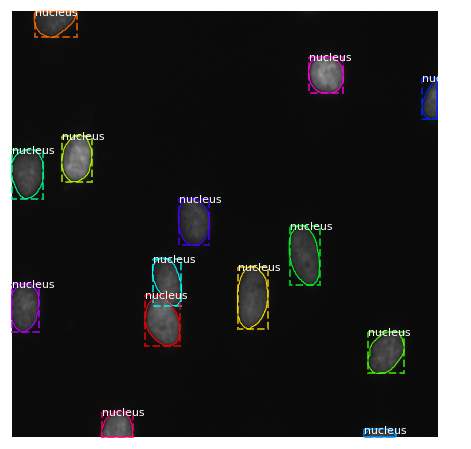

In [27]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (896, 896, 3)         min:    1.27551  max:  163.11735  float64
molded_images            shape: (1, 896, 896, 3)      min: -122.42449  max:   59.21734  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32


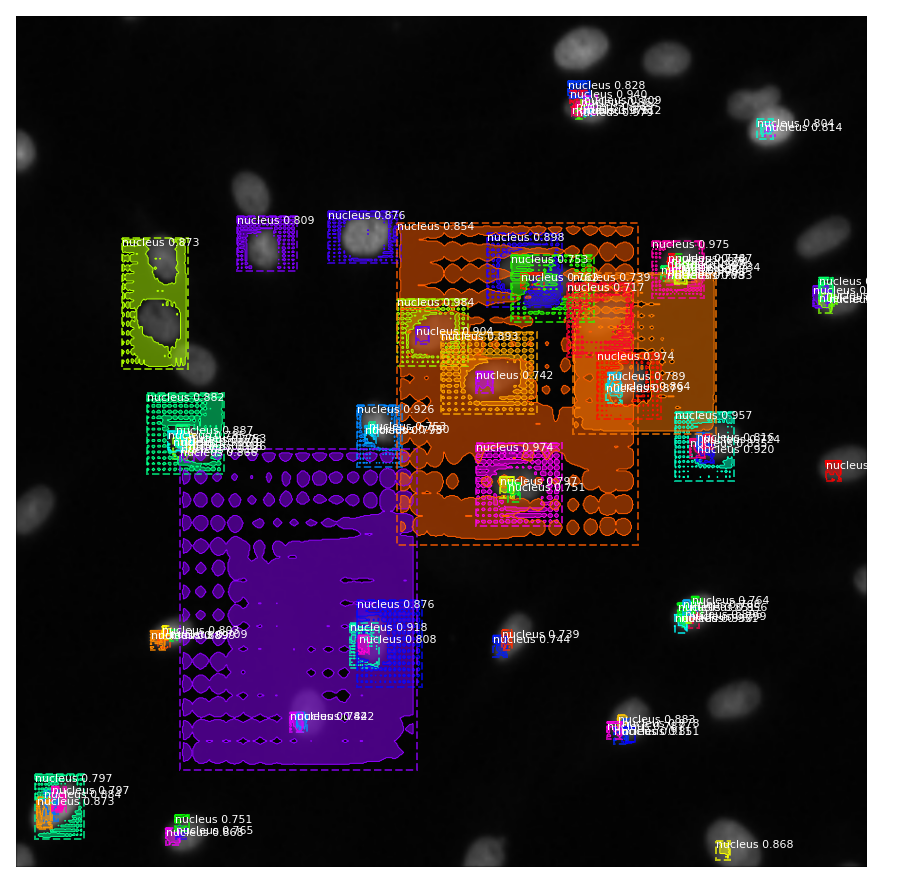

In [23]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

# Evaluation

In [24]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 30)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0


In [25]:
X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)

Getting and resizing test images ... 


checking a test image with masks ...
Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max: -103.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32

*** No instances to display *** 



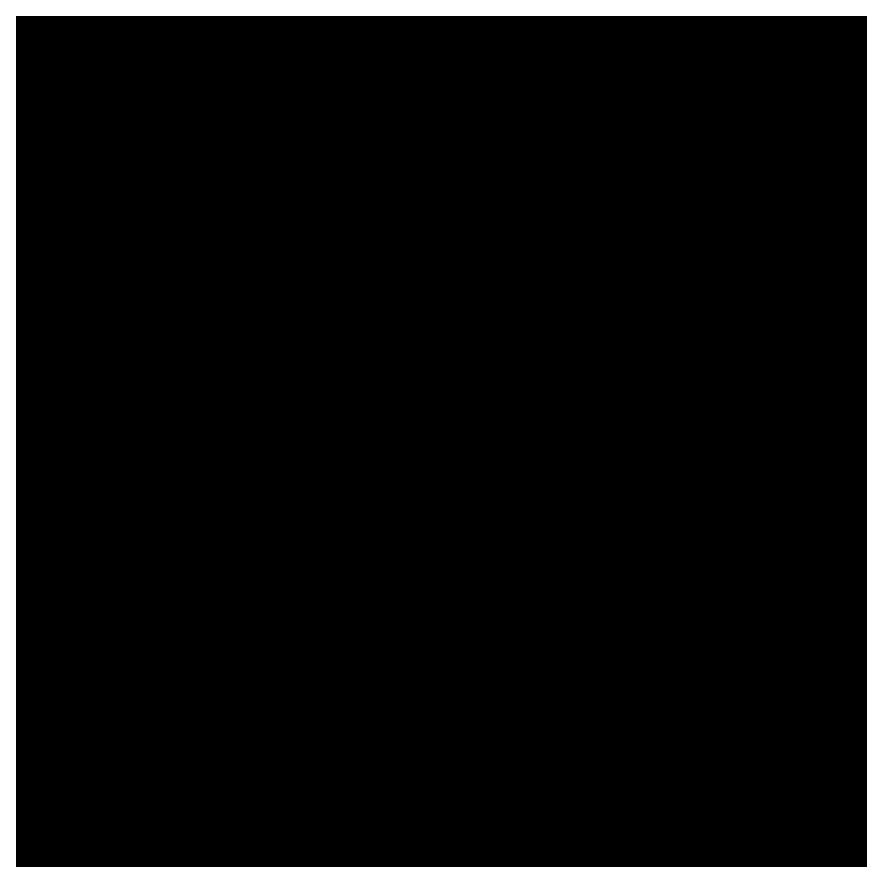

In [26]:
print("checking a test image with masks ...")
results = model.detect([X_test[20]], verbose=1)

r = results[0]
visualize.display_instances(X_test[20], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])